# Testing deep image caption

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3208476441006324531
]


In [2]:
from glob import iglob

from matplotlib import pylab as plt
%matplotlib inline

### Local imports

In [3]:
from data_manager import DataManager
from models import build_caption_model, build_image_encoder
from caption_generator import CaptionGenerator

Using TensorFlow backend.


### Constants

In [4]:
MAX_CAPTION_LENGTH = 36
BEAM_SIZE = 3
N_SAMPLES = 10

### Batch generators

In [5]:
dm_train = DataManager('./data/flickr8k_train.pkl')

dm_val = DataManager('./data/flickr8k_val.pkl', caption_length=dm_train.caption_length, 
                     return_image_features=False)
val_generator = dm_val.flow(shuffle=False)

### Model path

In [6]:
model_paths = list(iglob('./experiments/**/*.hdf5', recursive=True))
model_paths = sorted(model_paths, key=lambda x: os.path.getctime(x))

model_path = model_paths[-1]  # getting most fresh weights 
print(model_path)

./experiments/2017-08-22-09:56:10/checkpoints/checkpoint-0018.hdf5


### Generating examples

In [7]:
import numpy as np

from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences

class CaptionGenerator(object):
    def __init__(self, model_path, image_encoder, vocabulary, caption_length):
        self.model_path = model_path
        self.caption_model = load_model(model_path)

        self.image_encoder = image_encoder
        
        self.vocabulary = vocabulary
        self.inversed_vocabulary = dict((v, k) for k, v in self.vocabulary.items())
        
        self.caption_length = caption_length
        
    def _predict_next_words(self, image, partial_caption, n_words=3):
        image_features = self.image_encoder.predict(np.expand_dims(image, axis=0))
        prediction = self.caption_model.predict([image_features, np.expand_dims(partial_caption, axis=0)])
        
        next_words = np.argsort(prediction[0])[-n_words:]
        next_words_scores = np.sort(prediction[0])[-n_words:]
        
        return next_words, next_words_scores
    
    def _decode_caption(self, caption):
        return ' '.join([self.inversed_vocabulary[x] for x in caption])
    
    def generate_captions(self, image, max_caption_length=7, beam_size=3):
        partial_captions = [[[self.vocabulary['<s>']], 0]]

        done = False
        while not done:
            candidate_partial_captions = []
            for partial_caption, score in partial_captions:
                if partial_caption[-1] == self.vocabulary['<e>']:
                    continue
                    
                padded_partial_caption = pad_sequences(
                    [partial_caption],
                    maxlen=self.caption_length, padding='post',
                    value=self.vocabulary['<p>']
                )[0]
                next_words, next_words_scores = self._predict_next_words(image, padded_partial_caption, n_words=beam_size)
                
                for next_word, next_word_score in zip(next_words, next_words_scores):
                    candidate_partial_captions.append([partial_caption + [next_word],
                                                       score + next_word_score])
                    
            partial_captions = sorted(candidate_partial_captions, key=lambda x: x[1] / len(x[0]))[-beam_size:]

            done = True
            for partial_caption in partial_captions:
                if partial_caption[0][-1] != self.vocabulary['<e>'] and len(partial_caption[0]) <= max_caption_length:
                    done = False
                    break
            
        decoded_captions = list(map(self._decode_caption, [x[0] for x in partial_captions]))
        return decoded_captions[::-1]

In [8]:
image_encoder = build_image_encoder(dm_val.image_height, dm_train.image_width, dm_train.n_channels)
caption_generator = CaptionGenerator(model_path, image_encoder, dm_train.vocabulary, dm_train.caption_length)

<s> a boy skateboards down a shadow on a shadow is down a mattress is against a brick wall in front of a stone wall with a wall in of a wall in of of of of
<s> a boy skateboards down a shadow on a shadow is down a mattress is against a brick wall in front of a stone wall with a wall in of a wall in of of of <e>
<s> a boy skateboards down a shadow on a shadow is down a mattress is against a brick wall in front of a stone wall with a wall in of a wall in of of of is


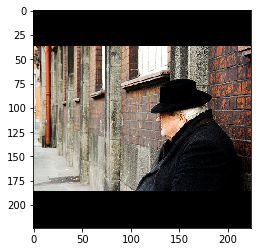

<s> a boy stare in the leaves with leaves with a pile in front of a leaves <e>
<s> a boy stare in the leaves with leaves with a pile in front of a pile <e>
<s> a boy stare in the leaves with leaves with a pile in front of a heads <e>


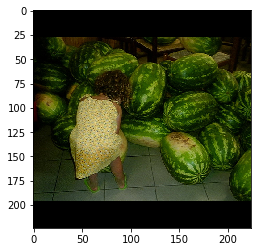

<s> a group of people dressed in pink suits standing in front of a picture <e>
<s> a group of people dressed in pink suits standing in front of a camp <e>
<s> a group of people dressed in pink suits standing in front of a wedding <e>


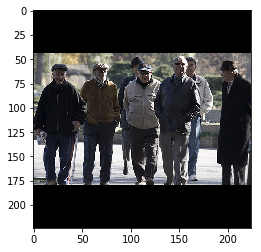

<s> a man is standing in front of front of front of front of front of front of front of a building with a building in of a building with of of of of of of of
<s> a man is standing in front of front of front of front of front of front of front of a building with a building in of a building with of of of of of of <e>
<s> a man is standing in front of front of front of front of front of front of front of a building with a building in of a building with of of of of of of a


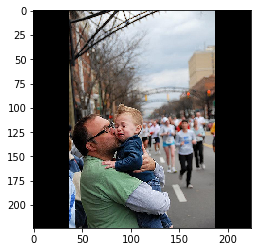

<s> the people are sitting in front of a river in front of front of a rural scenery <e>
<s> the people are sitting in front of a river in front of front of a rural view <e>
<s> the people are sitting in front of a river in front of front of a belongings belongings <e>


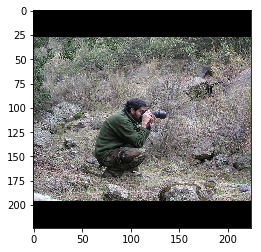

<s> a lone surfer skiing in the snow on the snow on the snow on the background <e>
<s> a lone surfer skiing in the snow on the snow on the snow on a background <e>
<s> a lone surfer skiing in the snow on the snow on the snow on the snow <e>


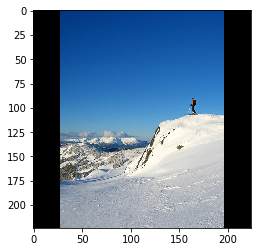

In [ ]:
batch = next(val_generator)

images = batch[0][0]
for image in images[:N_SAMPLES]:
    captions = caption_generator.generate_captions(image, max_caption_length=MAX_CAPTION_LENGTH, beam_size=BEAM_SIZE)
    print('\n'.join(captions))
    
    plt.imshow(image)
    plt.show()